In [1]:
from omegaconf import OmegaConf
from vitssm.models import build_model
from vitssm.data import get_dataset, get_dataloaders_continuous_next_frame
import torch
from einops import rearrange
from thop import profile

config = OmegaConf.load("configs/UPT/FINAL_upt_3d_t_cont_config.yml")
config.dataset.load_in_memory = False
config.model.upt_autoencoder_checkpoint_path = None

model = build_model(config.model)
#dataset = get_dataset(config.dataset)

#app_checkpoint_path = "/home/david/projects/ViTSSM/checkpoints/ViTSSM/UPT/vmdsprites-UPT_3D_T-32.pth"
#ckpt = torch.load(app_checkpoint_path)
#app_ckpt = {key[13:]: val for key, val in ckpt["model"].items() if key.startswith("approximator")}
#
#model.approximator.load_state_dict(app_ckpt)

x = torch.randn(1, 4, 3, 32, 32)
temporal_scale = 1
spatial_scale = 1

bs, cl, ch, ht, wt = x.shape

output_pos = rearrange(
    torch.stack(
        torch.meshgrid(
            [
                torch.arange(int(cl * temporal_scale)),
                torch.arange(int(ht * spatial_scale)),
                torch.arange(int(wt * spatial_scale))
            ], 
            indexing="ij",
        )   
    ),
    "ndim time height width -> (time height width) ndim",
).float()

dims = torch.tensor([int(cl * temporal_scale), int(ht * spatial_scale), int(wt * spatial_scale)])
output_pos = output_pos / (dims - 1) * 1000

train_loader, val_loader = get_dataloaders_continuous_next_frame(config.dataset)

In [1]:
from vitssm.data.datasets import VideoDataset
from vitssm.data.wrappers import VariableResolutionAEDatasetWrapper
from vitssm.data.samplers import PartitionBatchSampler
from torch.utils.data import DataLoader
from vitssm.data import get_dataloaders_srno
from omegaconf import OmegaConf

config = OmegaConf.load("/home/david/projects/ViTSSM/configs/SRNO/FINAL_srno_edsr_config.yml")

train_loader, val_loader = get_dataloaders_srno(config.dataset)

In [2]:
x = next(iter(train_loader))

In [1]:
from vitssm.models.dit import DiT_models
from vitssm.models.unet import UNet_models
from vitssm.utils import count_parameters
from vitssm.models import build_model
from omegaconf import OmegaConf

config = OmegaConf.load("/home/david/projects/ViTSSM/configs/UPT/FINAL_upt_3d_t_cont_no_ln_reg_config.yml")
#config = OmegaConf.load("/home/david/projects/ViTSSM/configs/UPT/FINAL_upt_vae_t_cont_no_ln_reg_config.yml")

model = build_model(config.model)

{'resolution': [4, 32, 32], 'ln_regularization': False}


In [2]:
model.autoencoder.decoder.input_affine

Identity()

In [5]:
from tqdm import tqdm
import torch
from vitssm.data.wrappers import resize_fn
from vitssm.utils.visual import unnormalize
from torchmetrics.image import PeakSignalNoiseRatio

metric = [PeakSignalNoiseRatio() for _ in range(4)]

for scale in range(4):
    dataset = SRImplicitDownsampledFast(
        VideoFrameDataset(
            "/home/david/projects/ViTSSM/data_store/VMDsprites_128/folds/test_0.csv",
            108,
            (128, 128),
        ),
        inp_size=32,
        scale_min=scale + 1,
        scale_max=scale + 1,
        train=False,
    )
    sampler = PartitionBatchSampler(dataset, 64, 100)
    loader = DataLoader(dataset, batch_sampler=sampler, num_workers=2, pin_memory=False)
    
    hr_size = int(32 * (scale + 1))
    print(hr_size)
    for batch in tqdm(loader):
        inp, coord, cell, gt = batch.values()

        inp, gt = unnormalize(inp), unnormalize(gt)

        pred = torch.stack([resize_fn(inp[i], hr_size) for i in range(inp.shape[0])])
        metric[scale].update(pred, gt)
    

res = {f"PSNR_{i+1}": metric[i].compute() for i in range(4)}
    

32


  0%|          | 0/1700 [00:00<?, ?it/s]

100%|██████████| 1700/1700 [01:33<00:00, 18.10it/s]


64


100%|██████████| 1700/1700 [01:50<00:00, 15.41it/s]


96


100%|██████████| 1700/1700 [02:16<00:00, 12.44it/s]


128


100%|██████████| 1700/1700 [02:39<00:00, 10.69it/s]


In [9]:
res

{'PSNR_1': tensor(60.4547),
 'PSNR_2': tensor(28.8664),
 'PSNR_3': tensor(27.2419),
 'PSNR_4': tensor(24.7802)}

In [1]:
from vitssm.data.datasets import VideoDataset, VideoFrameDataset
from vitssm.data.wrappers import VariableResolutionAEDatasetWrapper, SRImplicitDownsampledFast
from vitssm.data.samplers import PartitionBatchSampler
from torch.utils.data import DataLoader

dataset = SRImplicitDownsampledFast(
    VideoFrameDataset(
        "/home/david/projects/ViTSSM/data_store/VMDsprites_128/folds/test_0.csv",
        108,
        (128, 128),
    ),
    inp_size=32,
    scale_min=4,
    scale_max=4,
    train=False,
)
sampler = PartitionBatchSampler(dataset, 64, 100)
loader = DataLoader(dataset, batch_sampler=sampler, num_workers=2, pin_memory=False)

len(sampler.partitions)

100

In [4]:
from tqdm import tqdm

for x in tqdm(loader):
    pass

  6%|▌         | 1014/16900 [00:30<08:04, 32.80it/s]


KeyboardInterrupt: 

In [140]:
from vitssm.data import get_dataloaders_srno
from omegaconf import OmegaConf

config = OmegaConf.load("/home/david/projects/ViTSSM/configs/SRNO/FINAL_srno_edsr_config.yml")


train_loader, val_loaders = get_dataloaders_srno(config.dataset)

In [152]:
for [*args] in zip(*val_loaders):
    print(args)
    break

[{'inp': tensor([[[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.3569, 0.3569, 0.3569],
          [0.0039, 0.0039, 0.0039,  ..., 0.3569, 0.3569, 0.3569],
          [0.0039, 0.0039, 0.0039,  ..., 0.3569, 0.3569, 0.3569]],

         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.8510, 0.8510, 0.8510],
          [0.0039, 0.0039, 0.0039,  ..., 0.8510, 0.8510, 0.8510],
          [0.0039, 0.0039, 0.0039,  ..., 0.8510, 0.8510, 0.8510]],

         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039

In [191]:
loader = val_loaders

def train_step_1(batch):
    inp, coord, cell, gt = batch.values()
    print(inp.shape, coord.shape, cell.shape, gt.shape)

def train_step_2(*batches):
    for batch in batches:
        inp, coord, cell, gt = batch.values()
        print(inp.shape, coord.shape, cell.shape, gt.shape)
    
def train_step_3(x, y):
    print(x.shape, y.shape)

for args in zip(*loader) if isinstance(loader, tuple) else loader:
    train_step_2(*args if isinstance(args, (list, tuple)) else (args,))
    break


torch.Size([16, 3, 32, 32]) torch.Size([16, 32, 32, 2]) torch.Size([16, 2]) torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32]) torch.Size([16, 32, 32, 2]) torch.Size([16, 2]) torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32]) torch.Size([16, 32, 32, 2]) torch.Size([16, 2]) torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32]) torch.Size([16, 32, 32, 2]) torch.Size([16, 2]) torch.Size([16, 3, 32, 32])


In [1]:
import wandb
#wandb.login(key="a204a6391cfe118657c7853f9a3284bbe572935e")
from vitssm.utils.metrics import VariableResolutionRolloutMetricCollectionWrapper, get_metric_collection
import torch
from omegaconf import OmegaConf

config = OmegaConf.load("configs/UPT/FINAL_upt_3d_t_cont_config.yml")
metric_collection = VariableResolutionRolloutMetricCollectionWrapper(get_metric_collection(config), max_rescale_factor=4)

wandb.init(project="test", entity="davidkuernsteiner")

for _ in range(100):
    x, y, rescale_factor = torch.clamp(torch.randn(32, 16, 3, 32, 32), -1, 1), torch.clamp(torch.randn(32, 16, 3, 32, 32), -1, 1), int(torch.randint(1, 5, (1,)).item())

    metric_collection.update(x, y, rescale_factor)

metric_collection.compute()
wandb.log(metric_collection.compute(), step=1)

wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: davidkuernsteiner. Use `wandb login --relogin` to force relogin


In [2]:
from vitssm.models import build_model
from vitssm.data import get_dataloaders_srno
from vitssm.utils import count_parameters
from omegaconf import OmegaConf

config = OmegaConf.load("/home/david/projects/ViTSSM/configs/SRNO/FINAL_srno_edsr_config.yml")
model = build_model(config.model)
count_parameters(model)

2164742

torch.Size([128, 3, 32, 32])


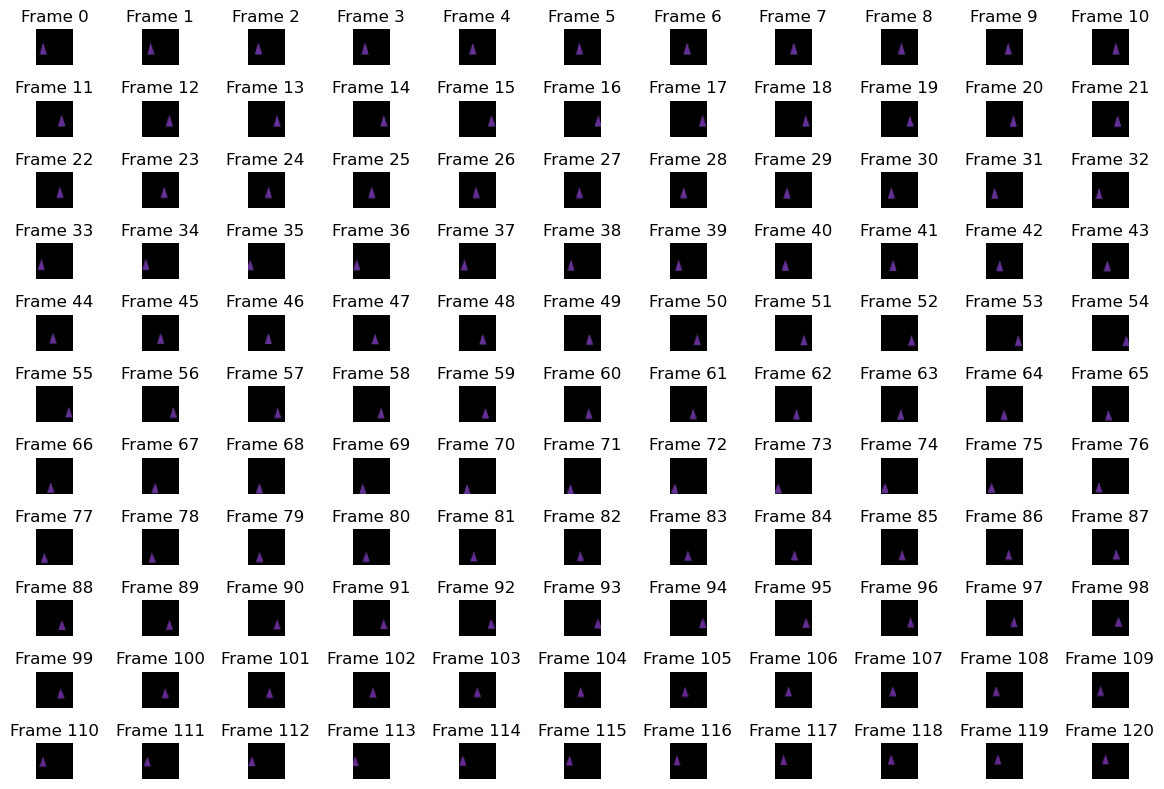

In [20]:
from vitssm.utils.visual import model_output_to_video, display_video_frames_in_grid
from einops import rearrange, repeat
from torchvision.io import write_video
import imageio
import numpy as np

bs, cl, ch, ht, wt = x.shape
spatial_scale = 1
temporal_scale = 1
device = torch.device("cuda")


model.eval()
model.to(device)

x_pred = model.rollout_frames(x.to(device), n_steps=128, temporal_scale=temporal_scale, spatial_scale=spatial_scale).squeeze(0).cpu()

print(x_pred.shape)
display_video_frames_in_grid(x_pred)
imageio.mimsave("x_pred.gif", [np.array(x) for x in rearrange(model_output_to_video(x_pred), "... c h w -> ... h w c")])

In [1]:
(64 + 2)*4+2

266

In [4]:
import numpy as np

[np.array(x) for x in x_pred]

/tmp/ipykernel_13560/2708407521.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  [np.array(x) for x in x_pred]


[array([[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32),
 array([[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1.,

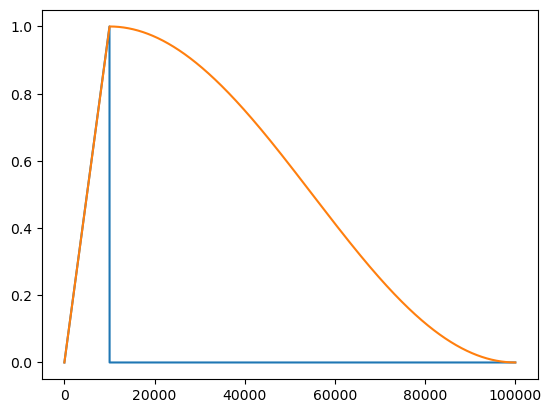

In [2]:
import matplotlib.pyplot as plt
import numpy as np

warmup_steps = 10000
decay_steps = 90000
scheduler_gamma = 0.0


def warm_and_exp_decay_lr(step: int):
    if step < warmup_steps:
        return step / warmup_steps

    return scheduler_gamma ** (step / decay_steps - warmup_steps / decay_steps)

def warm_and_cosine_decay_lr(step: int):
    if step < warmup_steps:
        return step / warmup_steps

    return scheduler_gamma + 0.5 * (1 - scheduler_gamma) * (1 + np.cos((step / decay_steps - warmup_steps / decay_steps) * np.pi))

x = list(range(100000))
y_exp = list(map(warm_and_exp_decay_lr, x))
y_cos = list(map(warm_and_cosine_decay_lr, x))
plt.plot(x, y_exp, label="exp")
plt.plot(x, y_cos, label="cos")

In [ ]:
from vitssm.models.upt._autoencoder import UPTVAE_M
from vitssm.models.upt._approximator import UPTA_M
from vitssm.utils import count_parameters
import torch
from einops import rearrange, repeat

ae = UPTVAE_M(resolution=(4, 32, 32)
app = UPTA_M(context_length=4)

#x = torch.randn(1, 4, 3, 32, 32)
#
#b, f, c, h, w = x.shape
#x = rearrange(x, "b f c h w -> (b f) c h w")
#output_pos = rearrange(
#    torch.stack(torch.meshgrid([torch.arange(32), torch.arange(32)], indexing="ij")),
#    "ndim height width -> (height width) ndim",
#).float()
#
#x = ae.encode(x)
#print(x.shape)
#x = rearrange(x, "(b f) t e -> b f t e", b=b, f=f)
#x = app(x)
#print(x.shape)

print("autoencoder: ", count_parameters(ae))
print("approximator: ", count_parameters(app))
print("total: ", count_parameters(ae) + count_parameters(app))

autoencoder:  2038275
approximator:  894720
total:  2932995


In [27]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def compare_downsampling(tensor, target_size):
    """
    Compare different downsampling algorithms visually.

    Args:
        tensor (torch.Tensor): Input image tensor in C, H, W format.
        target_size (tuple): Target size as (height, width).
    """
    # Ensure the tensor is in C, H, W format
    if tensor.ndim != 3:
        raise ValueError("Input tensor must be in C, H, W format.")

    # Normalize tensor for visualization
    tensor = tensor / tensor.max()

    # Convert to PIL image for compatibility with transforms
    to_pil = transforms.ToPILImage()
    pil_image = to_pil(tensor)

    # Define interpolation methods to compare
    interpolation_methods = {
        "Nearest": transforms.InterpolationMode.NEAREST,
        "Bilinear": transforms.InterpolationMode.BILINEAR,
        "Bicubic": transforms.InterpolationMode.BICUBIC,
        "Lanczos": transforms.InterpolationMode.LANCZOS,
    }

    # Create a subplot for each interpolation method plus the original
    fig, axes = plt.subplots(1, len(interpolation_methods) + 1, figsize=(18, 5))

    # Show the original image
    axes[0].imshow(pil_image)
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Show the resized images for each interpolation method
    for ax, (name, mode) in zip(axes[1:], interpolation_methods.items()):
        # Apply resizing
        resize_transform = transforms.Resize(target_size, interpolation=mode)
        resized_image = resize_transform(pil_image)

        # Show the resized image
        ax.imshow(resized_image)
        ax.set_title(name)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    
def compare_upsampling(tensor, model_out, target_size):
    """
    Compare different downsampling algorithms visually.

    Args:
        tensor (torch.Tensor): Input image tensor in C, H, W format.
        target_size (tuple): Target size as (height, width).
    """
    # Ensure the tensor is in C, H, W format
    if tensor.ndim != 3:
        raise ValueError("Input tensor must be in C, H, W format.")

    # Normalize tensor for visualization
    tensor = tensor / tensor.max()
    model_out = model_out / model_out.max()

    # Convert to PIL image for compatibility with transforms
    to_pil = transforms.ToPILImage()
    pil_image = to_pil(tensor)
    model_image = to_pil(model_out)

    # Define interpolation methods to compare
    interpolation_methods = {
        "Nearest": transforms.InterpolationMode.NEAREST,
        "Bilinear": transforms.InterpolationMode.BILINEAR,
        "Bicubic": transforms.InterpolationMode.BICUBIC,
        "Lanczos": transforms.InterpolationMode.LANCZOS,
    }

    # Create a subplot for each interpolation method plus the original
    fig, axes = plt.subplots(1, len(interpolation_methods) + 2, figsize=(18, 5))

    # Show the original image
    axes[0].imshow(pil_image)
    axes[0].set_title("Original")
    axes[0].axis("off")
    axes[1].imshow(model_image)
    axes[1].set_title("UPT")
    axes[1].axis("off")

    # Show the resized images for each interpolation method
    for ax, (name, mode) in zip(axes[2:], interpolation_methods.items()):
        # Apply resizing
        resize_transform = transforms.Resize(target_size, interpolation=mode)
        resized_image = resize_transform(pil_image)

        # Show the resized image
        ax.imshow(resized_image)
        ax.set_title(name)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_186492/1208528519.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/david/projects/ViTSSM/checkpoints/ContVidPred/U

torch.Size([4, 3, 32, 32]) torch.Size([65536, 3]) tensor(-1.) tensor(0.7373)
torch.Size([1, 4, 3, 128, 128])
torch.Size([3, 128, 128]) torch.Size([3, 32, 32]) tensor(0.) tensor(255.) tensor(0.) tensor(221.)


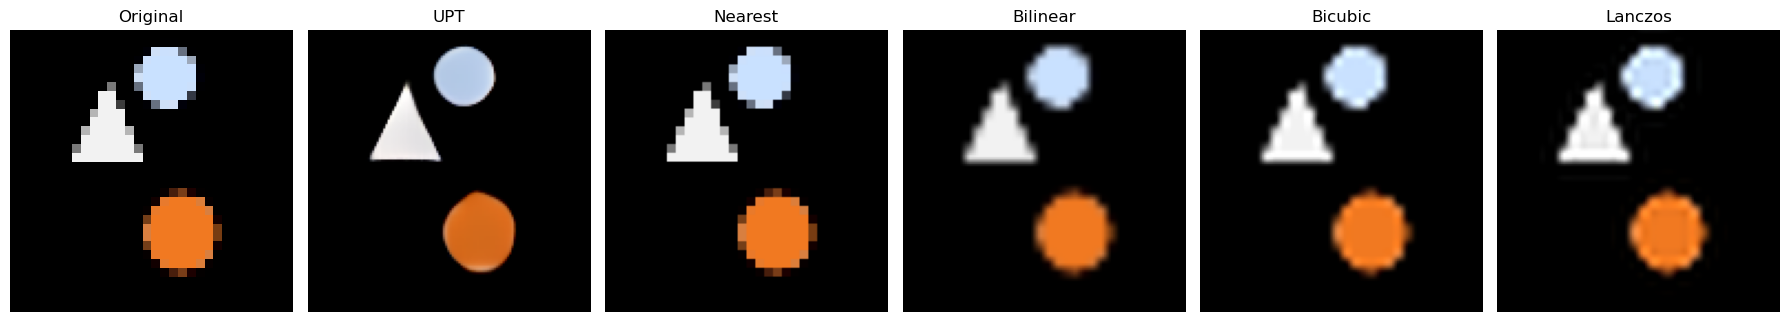

In [136]:
from vitssm.data.datasets import VideoDataset
from vitssm.utils.visual import unnormalize, model_output_to_video
from torchvision.transforms.functional import resize
from omegaconf import OmegaConf
from vitssm.models import build_model
from einops import rearrange

dataset = VideoDataset("data_store/VMDsprites_128/folds/train_0.csv", image_size=(32, 32))
config = OmegaConf.load("configs/UPT/FINAL_upt_vae_t_cont_config.yml")
model = build_model(config.model)
model.load_state_dict(torch.load("/home/david/projects/ViTSSM/checkpoints/ContVidPred/UPT/vmdsprites-0-UPT_VAE_T-cont.pth")["model"])
model.eval()
model.decoder.unbatch_mode = "video"
model.requires_grad_(False)

x = dataset[69][4:8]

t, c, h, w = x.shape
rescale_factor = 4

output_pos = rearrange(
    torch.stack(torch.meshgrid([torch.arange(t), torch.arange(h * rescale_factor), torch.arange(w * rescale_factor)], indexing="ij")),
    "ndim time height width -> (time height width) ndim",
).float()

dims = torch.tensor([t, h * rescale_factor, w * rescale_factor])
output_pos = output_pos / (dims - 1) * 1000

print(x.shape, output_pos.shape, x.min(), x.max())
x_pred = model(x.unsqueeze(0), output_pos.unsqueeze(0))
print(x_pred.shape)

x_pred = unnormalize(x_pred[0][0]) * 255
x = unnormalize(x[0]) * 255

print(x_pred.shape, x.shape, x_pred.min(), x_pred.max(), x.min(), x.max())
compare_upsampling(x, x_pred, target_size=(32 * rescale_factor, 32 * rescale_factor))

In [137]:
from PIL import Image
from einops import rearrange

Image.fromarray(rearrange(x_pred.detach().numpy().astype("uint8"), "c h w -> h w c")).save("x_pred.png")

In [12]:
from vitssm.data.datasets import VariableResolutionAEDatasetWrapper
from einops import rearrange
from vitssm.utils.visual import model_output_to_image, model_output_to_video

dataset = VariableResolutionAEDatasetWrapper(VideoDataset("data_store/VMDsprites_128/folds/train_0.csv", image_size=(128, 128)), 32, False, 4)

x, y = dataset[69]

In [13]:
coords = y["coords"].unsqueeze(0)
values = y["values"].unsqueeze(0)

t, h, w = tuple(len(torch.unique(coords[0, :, i])) for i in range(coords.size(-1)))

values = rearrange(values, "b (t h w) c -> b t c h w", t=t, h=h, w=w)

model_output_to_video(values[0])

IndexError: too many indices for tensor of dimension 4

In [19]:
import imageio
import numpy as np
imageio.mimsave("y.gif", [np.array(x) for x in rearrange(model_output_to_video(y), "... c h w -> ... h w c")])